# Analyze summary data, one line per file 
Here we use the 4-hourly summary data.
* Analog barometers are temperature-corrected, so can be considered a direct measure of true barometric pressure. However, the still need correcting to a height of 0 feet.
* Vibrating wire sensors need to be corrected with the corresponding temperature data, and height corrected to 0 feet.

## 1. Set up and Load transducers metadata

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import header
paths = header.setup_environment()
import platform
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/MERGED'
else:
    INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
display(transducersDF)

Linux


,serial,Fs,sensor,shielding,range_kPa_low,range_kPa_high,media,type,model,set_depth_ft,id,well,tmean,dig0,gf,tt,tt0,tf,bp,bp0
0,AirPressureShallow,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.81,6S.02374.88.HDH,shallow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1226420,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.46,6S.12264.20.HDD,shallow,30.68,9751.0,-0.006458,21.6,21.3,-0.008795,14.504,14.298
2,1226423,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-5.83,6S.12264.23.BDD,shallow,28.40,9605.0,-0.006347,21.6,22.2,-0.004197,14.504,14.298
3,1226419,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-6.71,6S.12264.19.HDD,shallow,27.57,10040.0,-0.006441,21.6,21.1,-0.010870,14.504,14.298
4,1226421,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-7.71,6S.12264.21.HDD,shallow,27.60,9787.0,-0.006724,21.6,21.3,-0.001145,14.504,14.298
5,AirPressureDeep,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.86,6I.0XXXX.XX.HDH,intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1226429,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.11,6I.12264.29.HDD,intermediate,30.60,9800.0,-0.006428,22.6,21.6,-0.002384,14.367,14.298
7,2151692,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-9.14,6I.21516.92.BDD,intermediate,25.88,9459.0,-0.008038,22.8,21.8,0.007666,14.296,14.388
8,2151691,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-18.31,6I.21516.91.HDD,intermediate,25.70,9414.0,-0.008142,22.8,21.5,0.008742,14.296,14.388
9,2149882,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-19.14,6I.21498.82.HDD,intermediate,25.96,9734.0,-0.008075,20.7,21.3,0.000675,14.602,14.389


# 2. Subset the summary of all files dataframe by Baro, 20 Hz, and 100 Hz subdirectories
Display the columns of each, after dropping empty columns.
* Baro only contains data columns for AirPressureShallow and AirPressureDeep.
* 20 Hz contains data columns for 1226423 and 2151692, plus corresponding temperature and stdev data
* 100 Hz contains data columns for '1226421', '1226419', '1226420', '2149882','2151691', and '1226429', plus corresponding temperature and stdev data

We plot:
- the barometric data
- the 100 Hz temperature data

Since none of these needs to be corrected (although later we will adjust barometric data to a height of 0 feet)

In [2]:
# if we do not remerge, we get the 1hz data too
all_dataframes = LLE.load_summary_csv(os.path.join(INPUTDIR, 'all2.csv'), split=True, remerge=False)
print('**** RETURNED ******')
for k in all_dataframes:
    print(k, all_dataframes[k].columns)
#display(all_dataframes['1hz'])

**** RETURNED ******
baro Index(['uploaddate', 'subdir', 'basename', 'AirPressureShallow',
       'AirPressureDeep', 'datetime'],
      dtype='object')
20hz Index(['uploaddate', 'subdir', 'basename', '1226423', '2151692', 'datetime'], dtype='object')
100hz Index(['1226421', '1226419', '1226420', '2149882', '2151691', '1226429',
       'uploaddate', 'subdir', 'basename', 'datetime'],
      dtype='object')


In [3]:
summarydf = LLE.load_summary_csv(os.path.join(INPUTDIR, 'all2.csv'), split=True, remerge=True)
print(len(summarydf))
display(summarydf.columns)

712


Index(['1226421', '1226419', '1226420', '2149882', '2151691', '1226429',
       'nearestminute', 'AirPressureShallow', 'AirPressureDeep', 'uploaddate',
       'subdir', 'basename', '1226423', '2151692', 'datetime'],
      dtype='object')

## 3. Examine thermometer data 
For each vibrating wire pressure transducer, there is a corresponding thermal record which code above translated from Therm(1)..Therm(6) etc. into serialno+'_temp'

{'HOME': '/home/thompsong', 'Developer': '/home/thompsong/Developer', 'repodir': '/home/thompsong/Developer/KSCRocketSeismoHydrology/Python/new_workflow', 'work': '/home/thompsong/work', 'local_outdir': '/home/thompsong/work/PROJECTS/KSC_EROSION', 'DROPBOX_TOP': '/home/thompsong/Dropbox', 'new_data': '/data/KSC/EROSION/fromdropboxinventory', 'DROPBOX_DATA_TOP': '/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA', 'dropbox_outdir': '/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/new_workflow', 'WELLDATA_TOP': '/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData', 'TOB3_DIR': '/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/Uploads', 'transducersCSVfile': '/home/thompsong/Developer/KSCRocketSeism

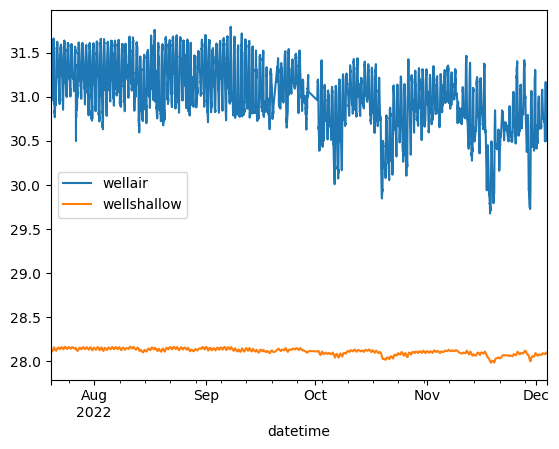

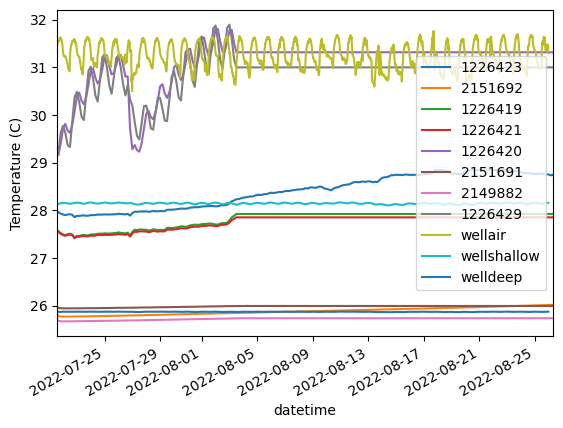

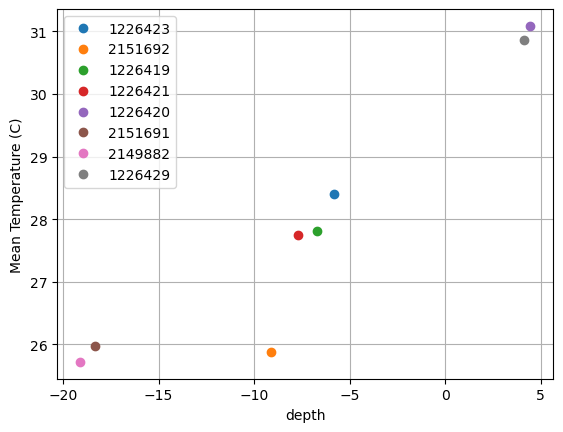

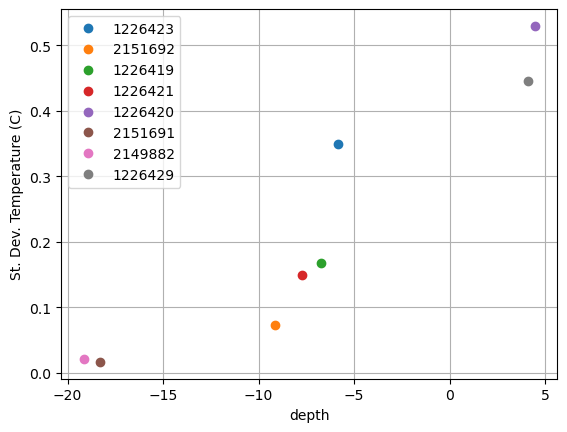

,depth,mean,Tstd,label
0,-5.83,28.396935,0.349913,1226423
1,-9.14,25.880246,0.072403,2151692
2,-6.71,27.804881,0.167933,1226419
3,-7.71,27.748095,0.148821,1226421
4,4.46,31.084981,0.529430,1226420
5,-18.31,25.980676,0.016835,2151691
6,-19.14,25.720083,0.021559,2149882
7,4.11,30.855316,0.445622,1226429


1226423_temp    28.396935
2151692_temp    25.880246
1226419_temp    27.804881
1226421_temp    27.748095
1226420_temp    31.084981
2151691_temp    25.980676
2149882_temp    25.720083
1226429_temp    30.855316
dtype: float64

In [40]:
temperaturedf = LLE.load_summary_csv(os.path.join(INPUTDIR, 'all2.csv'), split=True, remerge=True, temperatureData=True)
#temperaturedf = temperaturedf.reindex(sorted(temperaturedf.columns), axis=1) # for some reason sorting columns here or in qc_dataframe throws off the datetime plot
temperaturedf['nearestminute'] = pd.to_datetime(temperaturedf['nearestminute'])
print(paths)
nasa_temperaturedf = pd.read_csv(os.path.join(paths['DROPBOX_DATA_TOP'], 'Temperature.csv'), parse_dates=['datetime'])
nasa_temperaturedf['celsius'] =  (nasa_temperaturedf['Temperature']-32)/1.8
nasa_temperaturedf['celsius']=nasa_temperaturedf['celsius'].interpolate()
nasa_temperaturedf['wellair'] = (nasa_temperaturedf['celsius']/10+28.5)
#nasa_temperaturedf['wellshallow'] = (nasa_temperaturedf['celsius']/80+27.8).rolling(window=96).mean()
#nasa_temperaturedf['welldeep'] = (nasa_temperaturedf['celsius']/400+25.8).rolling(window=96).mean()
nasa_temperaturedf['wellshallow'] = (nasa_temperaturedf['celsius']/80+27.8).ewm(span=96).mean()
nasa_temperaturedf['welldeep'] = (nasa_temperaturedf['celsius']/400+25.8).ewm(span=96).mean()
nasa_temperaturedf.plot(x='datetime', y=['wellair', 'wellshallow'])
mask = (nasa_temperaturedf['datetime'] >= '2022/07/21') & (nasa_temperaturedf['datetime'] <= '2022/08/26')
subset_df = nasa_temperaturedf[mask]


fh, ax = plt.subplots(1,1)
lod = []
#thermalcolumns = [item for item in temperaturedf.columns if item.endswith('_temp')]
thermalcolumns = temperaturedf.columns[temperaturedf.columns.str.endswith('_temp')]
for tempcol in thermalcolumns:

    # try to graft on more temperature data
    last_non_null_value = temperaturedf[tempcol].dropna().iloc[-1]
    last_non_null_index = temperaturedf[tempcol].dropna().index[-1]
    temperaturedf.loc[last_non_null_index:, tempcol] = last_non_null_value

    col = tempcol.replace('_temp', '')
    this_transducer = LLE.get_transducer_metadata(col, transducersDF)
    depth = this_transducer['set_depth_ft']
    lod.append({'depth':depth, 'mean':temperaturedf[tempcol].mean(), 'Tstd':temperaturedf[tempcol].std(), 'label':col})
    this_df = temperaturedf.copy()[['nearestminute', tempcol]]
    this_df.dropna(subset=[tempcol], inplace=True)
    this_df.plot(ax=ax, x='nearestminute', y=tempcol, kind='line', xlabel='Date', ylabel='Temperature (C)', label=col, grid=True, xlim=[temperaturedf.iloc[0]['nearestminute'], temperaturedf.iloc[-1]['nearestminute']]).legend(bbox_to_anchor=(1.0,1.0), fontsize='small')
subset_df.plot(ax=ax, x='datetime', y='wellair')
subset_df.plot(ax=ax, x='datetime', y='wellshallow')
subset_df.plot(ax=ax, x='datetime', y='welldeep')
dftemp = pd.DataFrame(lod)
plt.show()

fh, ax = plt.subplots(1,1)
for thislabel in dftemp['label']:
    thisdf = dftemp[dftemp['label']==thislabel]
    thisdf.plot(ax=ax, x='depth', y='mean', style='o', ylabel='Mean Temperature (C)', label=thislabel, grid=True)    
plt.show()

fh, ax = plt.subplots(1,1)
for thislabel in dftemp['label']:
    thisdf = dftemp[dftemp['label']==thislabel]
    thisdf.plot(ax=ax, x='depth', y='Tstd', style='o', ylabel='St. Dev. Temperature (C)', label=thislabel, grid=True)    
plt.show()
display(dftemp)
display(temperaturedf[thermalcolumns].mean())


## 4. Plot raw barometric data


712
2022-12-02 08:24:14
2022-07-21 13:47:50


,datetime,basename
0,2022-07-21 13:47:50.000,20hz_Sensors_20Hz_20220721134750_000.csv
1,NaT,NaN
2,2022-07-21 16:00:00.050,20hz_Sensors_20Hz_20220721160000_001.csv
3,2022-07-21 20:00:00.050,20hz_Sensors_20Hz_20220721200000_002.csv
4,2022-07-22 00:00:00.050,20hz_Sensors_20Hz_20220722000000_003.csv
...,...,...
707,2022-12-01 12:00:00.050,20hz_Sensors_20Hz_20221201120000_119.csv
708,2022-12-01 16:00:00.050,20hz_Sensors_20Hz_20221201160000_120.csv
709,2022-12-01 20:00:00.050,20hz_Sensors_20Hz_20221201200000_121.csv
710,2022-12-02 00:00:00.050,20hz_Sensors_20Hz_20221202000000_122.csv


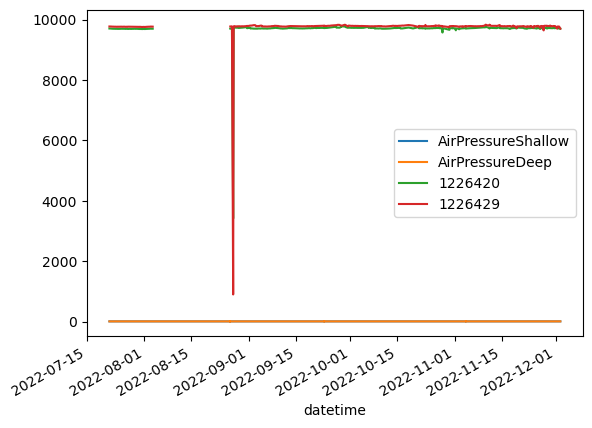

In [5]:
#all_dataframes['baro'].plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
#all_dataframes['100hz'].plot(x='datetime', y=['1226420', '1226429'], kind='line')
aircolumns = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
summarydf.plot(x='datetime', y=aircolumns, kind='line')
print(len(summarydf))
print(summarydf.iloc[-1]['datetime'])
print(summarydf.iloc[0]['datetime'])
display(summarydf[['datetime', 'basename']])


## 5. Correct all barometers and vibrating wire sensor data
- barometers are corrected for height only
- vibrating wire sensors in air are corrected for height also
- all vibrating wire sensors are corrected for sensitivity, and temperature
- vibrating wire sensors in water are corrected for barometric pressure too, from vibrating wire sensor in air

Applying height correction for AirPressureShallow
Applying height correction for AirPressureDeep
Applying calibration correction for 1226420
mean before: 9723.397058681434, after: 0.1782597950352973
min, max before: 336.4000244140625, 30790.96
min, max after: -135.87606168, 60.79948664233399
Applying air pressure correction for 1226420
Applying height correction for 1226420
Applying calibration correction for 1226429
mean before: 9826.620645310093, after: -0.1711175080532777
min, max before: 905.2364501953124, 28474.033203125
min, max after: -120.0366854296875, 57.17554009814453
Applying air pressure correction for 1226429
Applying height correction for 1226429


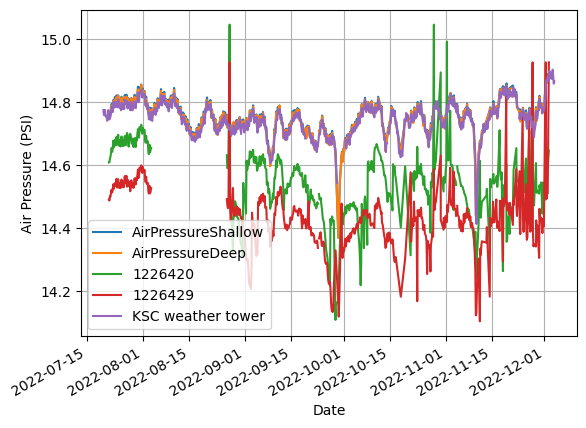

,AirPressureShallow,AirPressureDeep,1226420,1226429,KSC
count,705.000000,705.000000,568.000000,568.000000,799.000000
mean,14.744760,14.740857,14.540186,14.425582,14.746117
std,0.182592,0.182372,0.114430,0.105601,0.054358
min,10.154696,10.154692,14.046667,13.926894,14.413393
25%,14.720269,14.716602,14.473963,14.378661,14.714226
50%,14.756270,14.752972,14.546667,14.426894,14.749881
75%,14.789206,14.785845,14.608309,14.478442,14.781427
max,14.889966,14.887262,15.046667,14.926894,14.903621


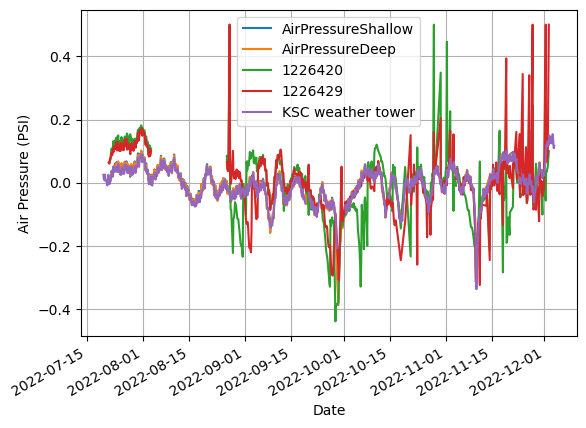

Applying calibration correction for 1226421
mean before: 9168.658256423305, after: 4.157729883809694
min, max before: 9168.1572265625, 9169.1572265625
min, max after: 4.15437480859375, 4.16109880859375
Applying temperature correction for 1226421
Applying calibration correction for 1226419
mean before: 9489.766545025032, after: 3.5440536834937597
min, max before: 9489.26776953125, 9490.26776953125
min, max after: 3.5408252964492157, 3.547266296449216
Applying temperature correction for 1226419
Applying calibration correction for 2149882
mean before: 8628.360803669677, after: 8.928036510367376
min, max before: 8627.861, 8628.861
min, max after: 8.923997424999994, 8.932072424999994
Applying temperature correction for 2149882
Applying calibration correction for 2151691
mean before: 8358.803557520907, after: 8.59140943466478
min, max before: 8358.303, 8359.303
min, max after: 8.587342974, 8.595484974000001
Applying temperature correction for 2151691
Applying calibration correction for 12264

<Axes: xlabel='datetime'>

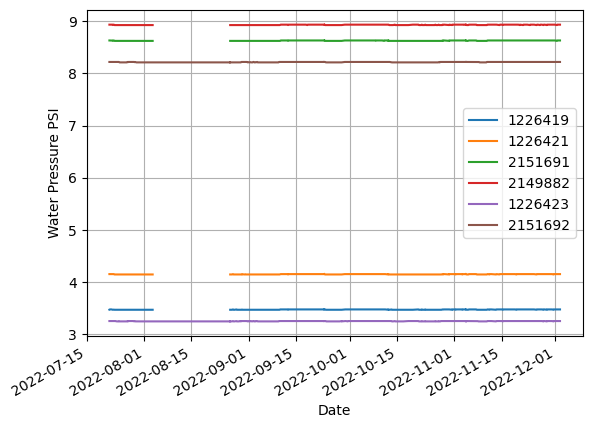

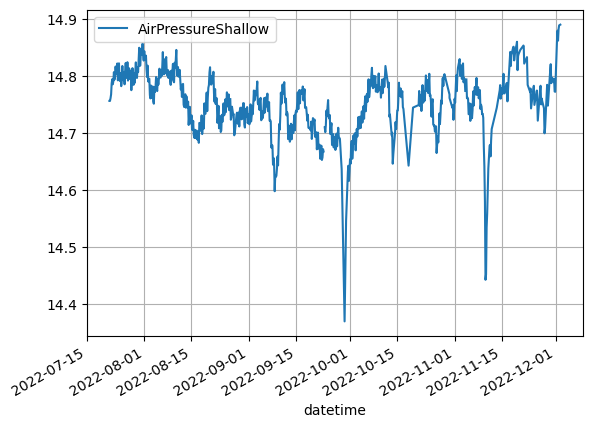

In [9]:
'''
dfbaro_elevationRemoved_PSI = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True)  
dfbaro_elevationRemoved_PSI.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
df100hz_elevationRemoved_aircolumnonly = LLE.correctBarometricData(df100hz_thermal, aircolumns[2:], transducersDF, temperatureCorrect=True, heightCorrect=True)
df100hz_elevationRemoved_PSI = LLE.rawdf2psidf(df100hz_elevationRemoved_aircolumnonly, transducersDF, temperatureCorrect=True, airpressureColumn='1226429', depthCorrect=False)
df100hz_elevationRemoved_PSI.plot(x='datetime', y=aircolumns[2:], kind='line')
'''
correcteddf = LLE.correctBarometricData(summarydf, aircolumns, transducersDF, temperatureCorrect=False, heightCorrect=True)  
ax=correcteddf.plot(x='datetime', y=aircolumns, kind='line', grid=True)
airstatsdf = correcteddf[aircolumns].describe()
#display(correcteddf[aircolumns].mean())
#display(correcteddf[aircolumns[2:]])
#correcteddf = LLE.correctBarometricData(correcteddf, aircolumns[2:], transducersDF, temperatureCorrect=False, heightCorrect=False)
#correcteddf = LLE.rawdf2psidf(correcteddf, transducersDF, temperatureCorrect=True, airpressureColumn='1226429', depthCorrect=False)
#correcteddf.plot(x='datetime', y=aircolumns[2:], kind='line')
#display(correcteddf[aircolumns[2:]])

dfnasa = pd.read_csv('Barometric Pressure.csv')
dfnasa['datetime']=pd.to_datetime(dfnasa['datetime'])
dfnasa = dfnasa.set_index('datetime')
dfnasa = dfnasa.resample('4h').median()
dfnasa.reset_index(inplace=True)
dfnasa.plot(ax=ax, x='datetime', y='PSI', label='KSC weather tower', ylabel='Air Pressure (PSI)', xlabel='Date', grid=True)
plt.show()
airstatsdf['KSC']=dfnasa['PSI'].describe()
display(airstatsdf)

# demeaned plot
demeaneddf = pd.DataFrame()
demeaneddf['datetime'] = correcteddf['datetime']
for col in aircolumns:
    demeaneddf[col] = correcteddf[col] - correcteddf[col].median()
ax=demeaneddf.plot(x='datetime', y=aircolumns, kind='line')
demeaneddf2 = pd.DataFrame()
demeaneddf2['datetime'] = dfnasa['datetime']
demeaneddf2['PSI'] = dfnasa['PSI'] - dfnasa['PSI'].median()
demeaneddf2.plot(ax=ax,x='datetime', y='PSI', kind='line', label='KSC weather tower', ylabel='Air Pressure (PSI)', xlabel='Date', grid=True)
plt.show()

watercolumns = ['1226419', '1226421', '2151691', '2149882', '1226423', '2151692']
#correcteddf = LLE.rawdf2psidf(correcteddf, transducersDF, temperatureCorrect=True, airpressureColumn='AirPressureShallow', depthCorrect=False)
correcteddf = LLE.rawdf2psidf(correcteddf, transducersDF, temperatureCorrect=True, airpressureColumn=None, depthCorrect=False)
correcteddf.plot(x='datetime', y=watercolumns, ylabel='Water Pressure PSI', xlabel='Date', grid=True)

correcteddf.plot(x='datetime', y=aircolumns[0], kind='line', grid=True)

## 6. Merge the dataframes after rounding timestamps to nearest minute
All time series from the all2.csv are 4-hourly since we have only 1 file per 4 hours. So we can round to the nearest minute to align times that are generally within 1-s

Drop columns we do not need

In [ ]:
LLE.round_datetime(df100hz_elevationRemoved_PSI, freq='min' )
LLE.round_datetime(dfbaro_elevationRemoved_PSI, freq='min')
dfmerged1 = LLE.merge_and_drop(df100hz_elevationRemoved_PSI, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged1)
dfmerged1.plot(x='nearestminute', y=aircolumns, kind='line')

## 7. Correlate the air pressure columns - and compare their means too


In [ ]:
print(len(correcteddf))
dfmerged1 = correcteddf.copy()
xcorrdf1, dcshiftdf1 = LLE.xcorr_columns(dfmerged1, aircolumns)
dfshifted1, dcshifts1 = LLE.apply_dcshifts(dfmerged1, xcorrdf1, dcshiftdf1)
dfshifted1.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

## 8. Repeat the analysis, but don't make a temperature correction
Improves correlation between 1226420 and analog barometers by 2%, but degrades 1226429 against same by almost 1%
Improves correlation between 1226420 and 1226429 by 4% 
However, if we stick to using 1226429, this loss in performance is fine.
Best shifts are now:
* +14.423795 PSI to align 1226420 with AirPressureShallow
* +14.556290 PSI to align 1226429 with AirPressureShallow

In [ ]:
df100hz_elevationRemoved_aircolumnonly_noT = LLE.correctBarometricData(df100hz_thermal, ['1226420', '1226429'], transducersDF, temperatureCorrect=False, heightCorrect=True)

LLE.round_datetime(df100hz_elevationRemoved_aircolumnonly_noT, freq='min' )
dfmerged2 = LLE.merge_and_drop(df100hz_elevationRemoved_aircolumnonly_noT, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged2)

xcorrdf2, dcshiftdf2 = LLE.xcorr_columns(dfmerged2, aircolumns)
dfshifted2, dcshifts2 = LLE.apply_dcshifts(dfmerged2, xcorrdf2, dcshiftdf2)
dfshifted2.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

dfxcorrdiff = xcorrdf2-xcorrdf1
dfxcorrdiff_styled = dfxcorrdiff.style.set_caption('Difference in cross-correlation')
dfshiftdiff = dcshiftdf2-dcshiftdf1
dfshiftdiff_styled = dfshiftdiff.style.set_caption('Difference in DC levels')

display(dfxcorrdiff_styled)
display(dfshiftdiff_styled)

## 9. Full workflow for 100 Hz data


In [ ]:
# 10.1: Get raw 100 Hz data and remove anything with spikes

# 10.2: Correct analog and digital air column transducers for calibration, elevation above water, and apply DC shift (no temperature correction)
dfbaro_dcshifted = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)
df100hz_dcshifted = LLE.correctBarometricData(all_dataframes['100hz'], aircolumns[2:], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)

# 10.3: Merge and plot
LLE.round_datetime(df100hz_dcshifted, freq='min')
LLE.round_datetime(dfbaro_dcshifted, freq='min')
dfmerged_dcshifted = LLE.merge_and_drop(dfbaro_dcshifted, df100hz_dcshifted, on='nearestminute', drop=False)
display(dfmerged_dcshifted)
dfmerged_dcshifted.plot(x='nearestminute', y=aircolumns, style='.', ylabel='PSI')

# 10.4: Correct digital water column transducers for calibration and barometric pressure
correctedAllSensorsPSI = LLE.rawdf2psidf(dfmerged_dcshifted, transducersDF, temperatureCorrect=False, airpressureColumn='1226429', depthCorrect=False)
watercolumns = ['1226419', '1226421', '2151691', '2149882']
display(correctedAllSensorsPSI[watercolumns])

# 10.5: plot PSI
correctedAllSensorsPSI.plot(x='nearestminute', y=aircolumns+watercolumns, style='.', ylabel='PSI')

# 10.6: convert to water levels in meters
correctedAllSensorsMeters = LLE.psi2meters(correctedAllSensorsPSI, watercolumns)
correctedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.7: convert to water levels in meters relative to the set depth measured by Steve Krupa
relativeAllSensorsMeters = LLE.relative_to_set_depth(correctedAllSensorsMeters, transducersDF, watercolumns)
relativeAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.8: estimate correct set depths from median of each, and shift by this amount
estimatedAllSensorsMeters = LLE.estimate_sensor_depths(correctedAllSensorsMeters, watercolumns)
estimatedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')   